# About Dataset

## Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

## Content
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
import warnings

warnings.filterwarnings("ignore")



2025-12-24 09:51:11.353029: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-24 09:51:11.370048: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-24 09:51:11.952092: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-24 09:51:14.299639: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [2]:
df = pd.read_csv('../data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Describe inputs

df.drop('Class',axis=1).describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000


In [4]:
# Check for missing values

df.isnull().sum().max()

np.int64(0)

In [5]:
# Check columns

df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

No Frauds:  284315 --- 99.83 % of the dataset
Frauds:     492 --- 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

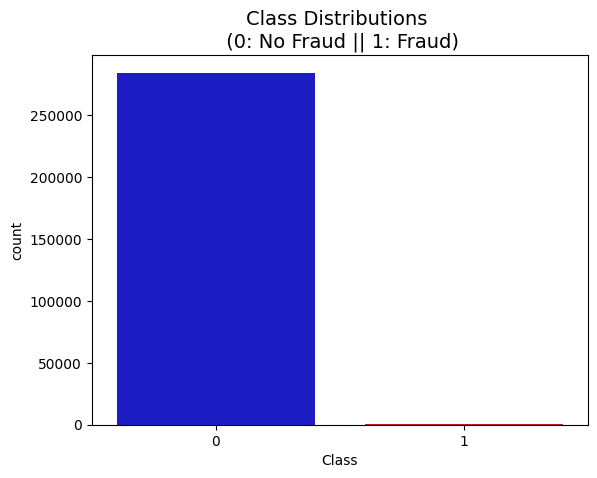

In [6]:
# Plot the distribution of the class

num_no_fraud = df['Class'].value_counts()[0]
num_fraud = df['Class'].value_counts()[1]

print('No Frauds: ', num_no_fraud, '---',round(num_no_fraud/len(df) * 100,2), '% of the dataset')
print('Frauds:    ',num_fraud, '---', round(num_fraud/len(df) * 100,2), '% of the dataset')

colors = ["#0101DF", "#DF0101"]

sns.countplot(x='Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

# Transaction amount and time

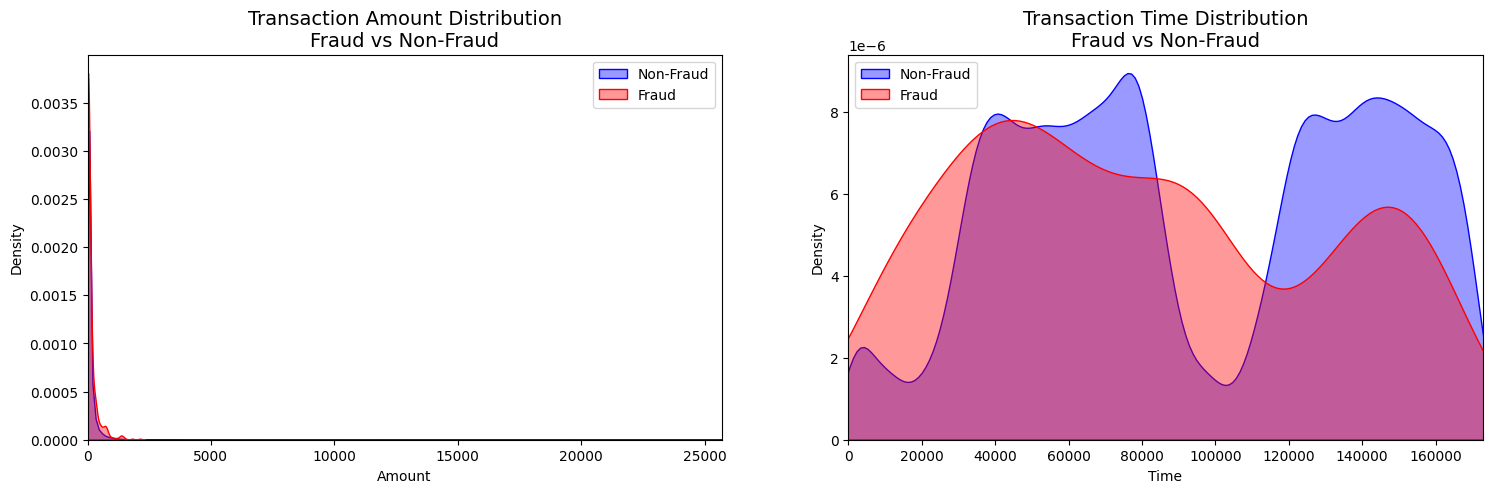

In [7]:
fraud = df[df['Class'] == 1]
nonfraud = df[df['Class'] == 0]

fig, ax = plt.subplots(1, 2, figsize=(18,5))

# ---------- Amount ----------
sns.kdeplot(nonfraud['Amount'], ax=ax[0], label='Non-Fraud', color='blue', fill=True, alpha=0.4)
sns.kdeplot(fraud['Amount'], ax=ax[0], label='Fraud', color='red', fill=True, alpha=0.4)
ax[0].set_title('Transaction Amount Distribution\nFraud vs Non-Fraud', fontsize=14)
ax[0].set_xlim(0, df['Amount'].max())
ax[0].legend()


# ---------- Time ----------
sns.kdeplot(nonfraud['Time'], ax=ax[1], label='Non-Fraud', color='blue', fill=True, alpha=0.4)
sns.kdeplot(fraud['Time'], ax=ax[1], label='Fraud', color='red', fill=True, alpha=0.4)
ax[1].set_title('Transaction Time Distribution\nFraud vs Non-Fraud', fontsize=14)
ax[1].set_xlim(0, df['Time'].max())
ax[1].legend()

plt.show()


## Transaction Amount Distribution

- Fraud and non-fraud transactions occur at very similar transaction amounts

- There is no clear “fraud amount cluster”

- Fraud does NOT always happen at higher values

- Small transactions are extremely common for both classes

- The distribution overlap is nearly perfect → no separation

## Transaction Time Distribution

- Both fraud and non-fraud transactions happen throughout the day

- Fraud does NOT spike at specific times

- The distribution overlap is large

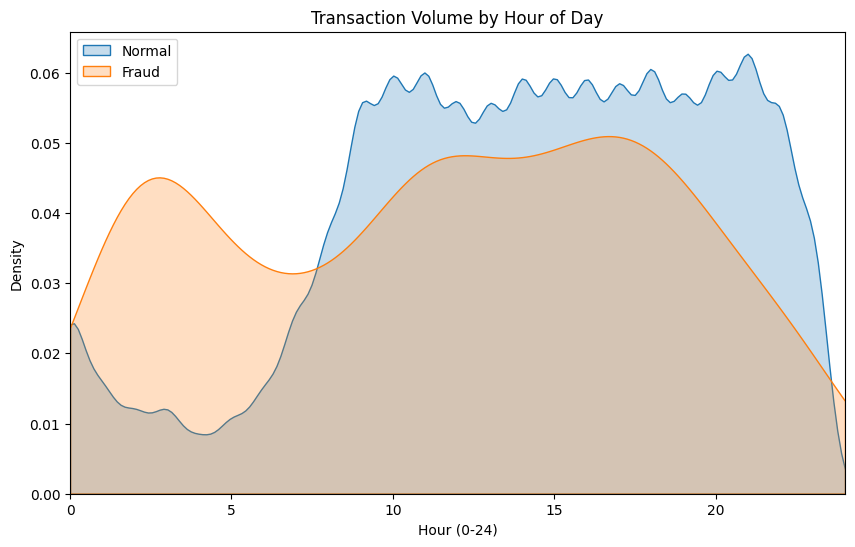

In [8]:
hour_df = df.copy()

hour_df['Hour'] = df['Time'].apply(lambda x: np.floor(x / 3600) % 24)

plt.figure(figsize=(10, 6))

# Added clip=(0, 24) to force the axis range
sns.kdeplot(hour_df[hour_df['Class'] == 0]['Hour'], label='Normal', shade=True, clip=(0, 24))
sns.kdeplot(hour_df[hour_df['Class'] == 1]['Hour'], label='Fraud', shade=True, clip=(0, 24))

plt.title('Transaction Volume by Hour of Day')
plt.xlabel('Hour (0-24)')
plt.xlim(0, 24) # Optional: Hard limit the x-axis view
plt.legend()
plt.show()

1. Normal Transactions (Blue Area) Follow "Human Time"
    - The blue curve behaves exactly as you would expect for legitimate human activity:

    - Sleeping: Activity drops significantly around hour 0 (midnight) and hits rock bottom around hour 4–5 AM.

    - Waking: Activity spikes sharply around hour 8–9 AM (start of the workday).

    - Active: It stays high and jagged throughout the day (9 AM – 10 PM) before tapering off again.

2. Fraud Transactions (Orange Line) Don't Sleep
    - The orange curve is completely different and highly suspicious:

    - The "Night" Spike: Look at the massive hump around hour 2 to hour 4 AM. While normal people are sleeping (the blue line is crashing), fraudsters are highly active.

    - Inverse Behavior: At hour 3 AM, the density of fraud is actually higher than the density of normal transactions. This crossover point is a critical signal for your model.

    - The "Lunch" Dip: Interestingly, the fraud rate seems to dip slightly around hour 12–13 (mid-day), exactly when normal transaction volume is high.

# Transaction with amount = 0

In [9]:
zero_amt = df[df['Amount'] == 0]
zero_amt.shape[0], df.shape[0]


(1825, 284807)

In [10]:
zero_amt['Class'].value_counts(normalize=True)


Class
0    0.985205
1    0.014795
Name: proportion, dtype: float64

In [11]:
df['Class'].value_counts(normalize=True)


Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

- Fraud rate (Amount = 0) ≈ 1.48%
- Overall fraud rate ≈ 0.17%

=> Zero-amount transactions are significantly more likely to be fraudulent than regular transactions.

In [12]:
zero_df = df.copy()

zero_df['is_zero_amount']= (df['Amount'] == 0).astype(int)

zero_df.groupby('is_zero_amount')['Class'].mean()


is_zero_amount
0    0.001643
1    0.014795
Name: Class, dtype: float64

In [13]:
from scipy.stats import ks_2samp

fraud_zero = df[(df['Class']==1) & (df['Amount']==0)]
fraud_nonzero = df[(df['Class']==1) & (df['Amount']>0)]

ks_2samp(fraud_zero['Time'], fraud_nonzero['Time'])


KstestResult(statistic=np.float64(0.2955794504181601), pvalue=np.float64(0.01796912945628086), statistic_location=np.float64(83934.0), statistic_sign=np.int8(-1))

Zero-amount fraud is likely automated probing, not normal purchases.

In [14]:
features = [c for c in df.columns if c.startswith('V')]

zero = df[df['Amount']==0]
nonzero = df[df['Amount']>0]

ks_scores = {}
for f in features:
    ks_scores[f] = ks_2samp(zero[f], nonzero[f]).statistic

sorted(ks_scores.items(), key=lambda x: x[1], reverse=True)[:5]


[('V4', np.float64(0.4843547723593049)),
 ('V10', np.float64(0.2760999775095817)),
 ('V26', np.float64(0.2644781104718118)),
 ('V2', np.float64(0.24571694622524518)),
 ('V15', np.float64(0.2430029733243113))]

- 1. It can be Testing Transaction.
- 2. Or it may be zero amount transaction which is performed after applying immediate refunds or other vouchers.

# Correlation Matrix

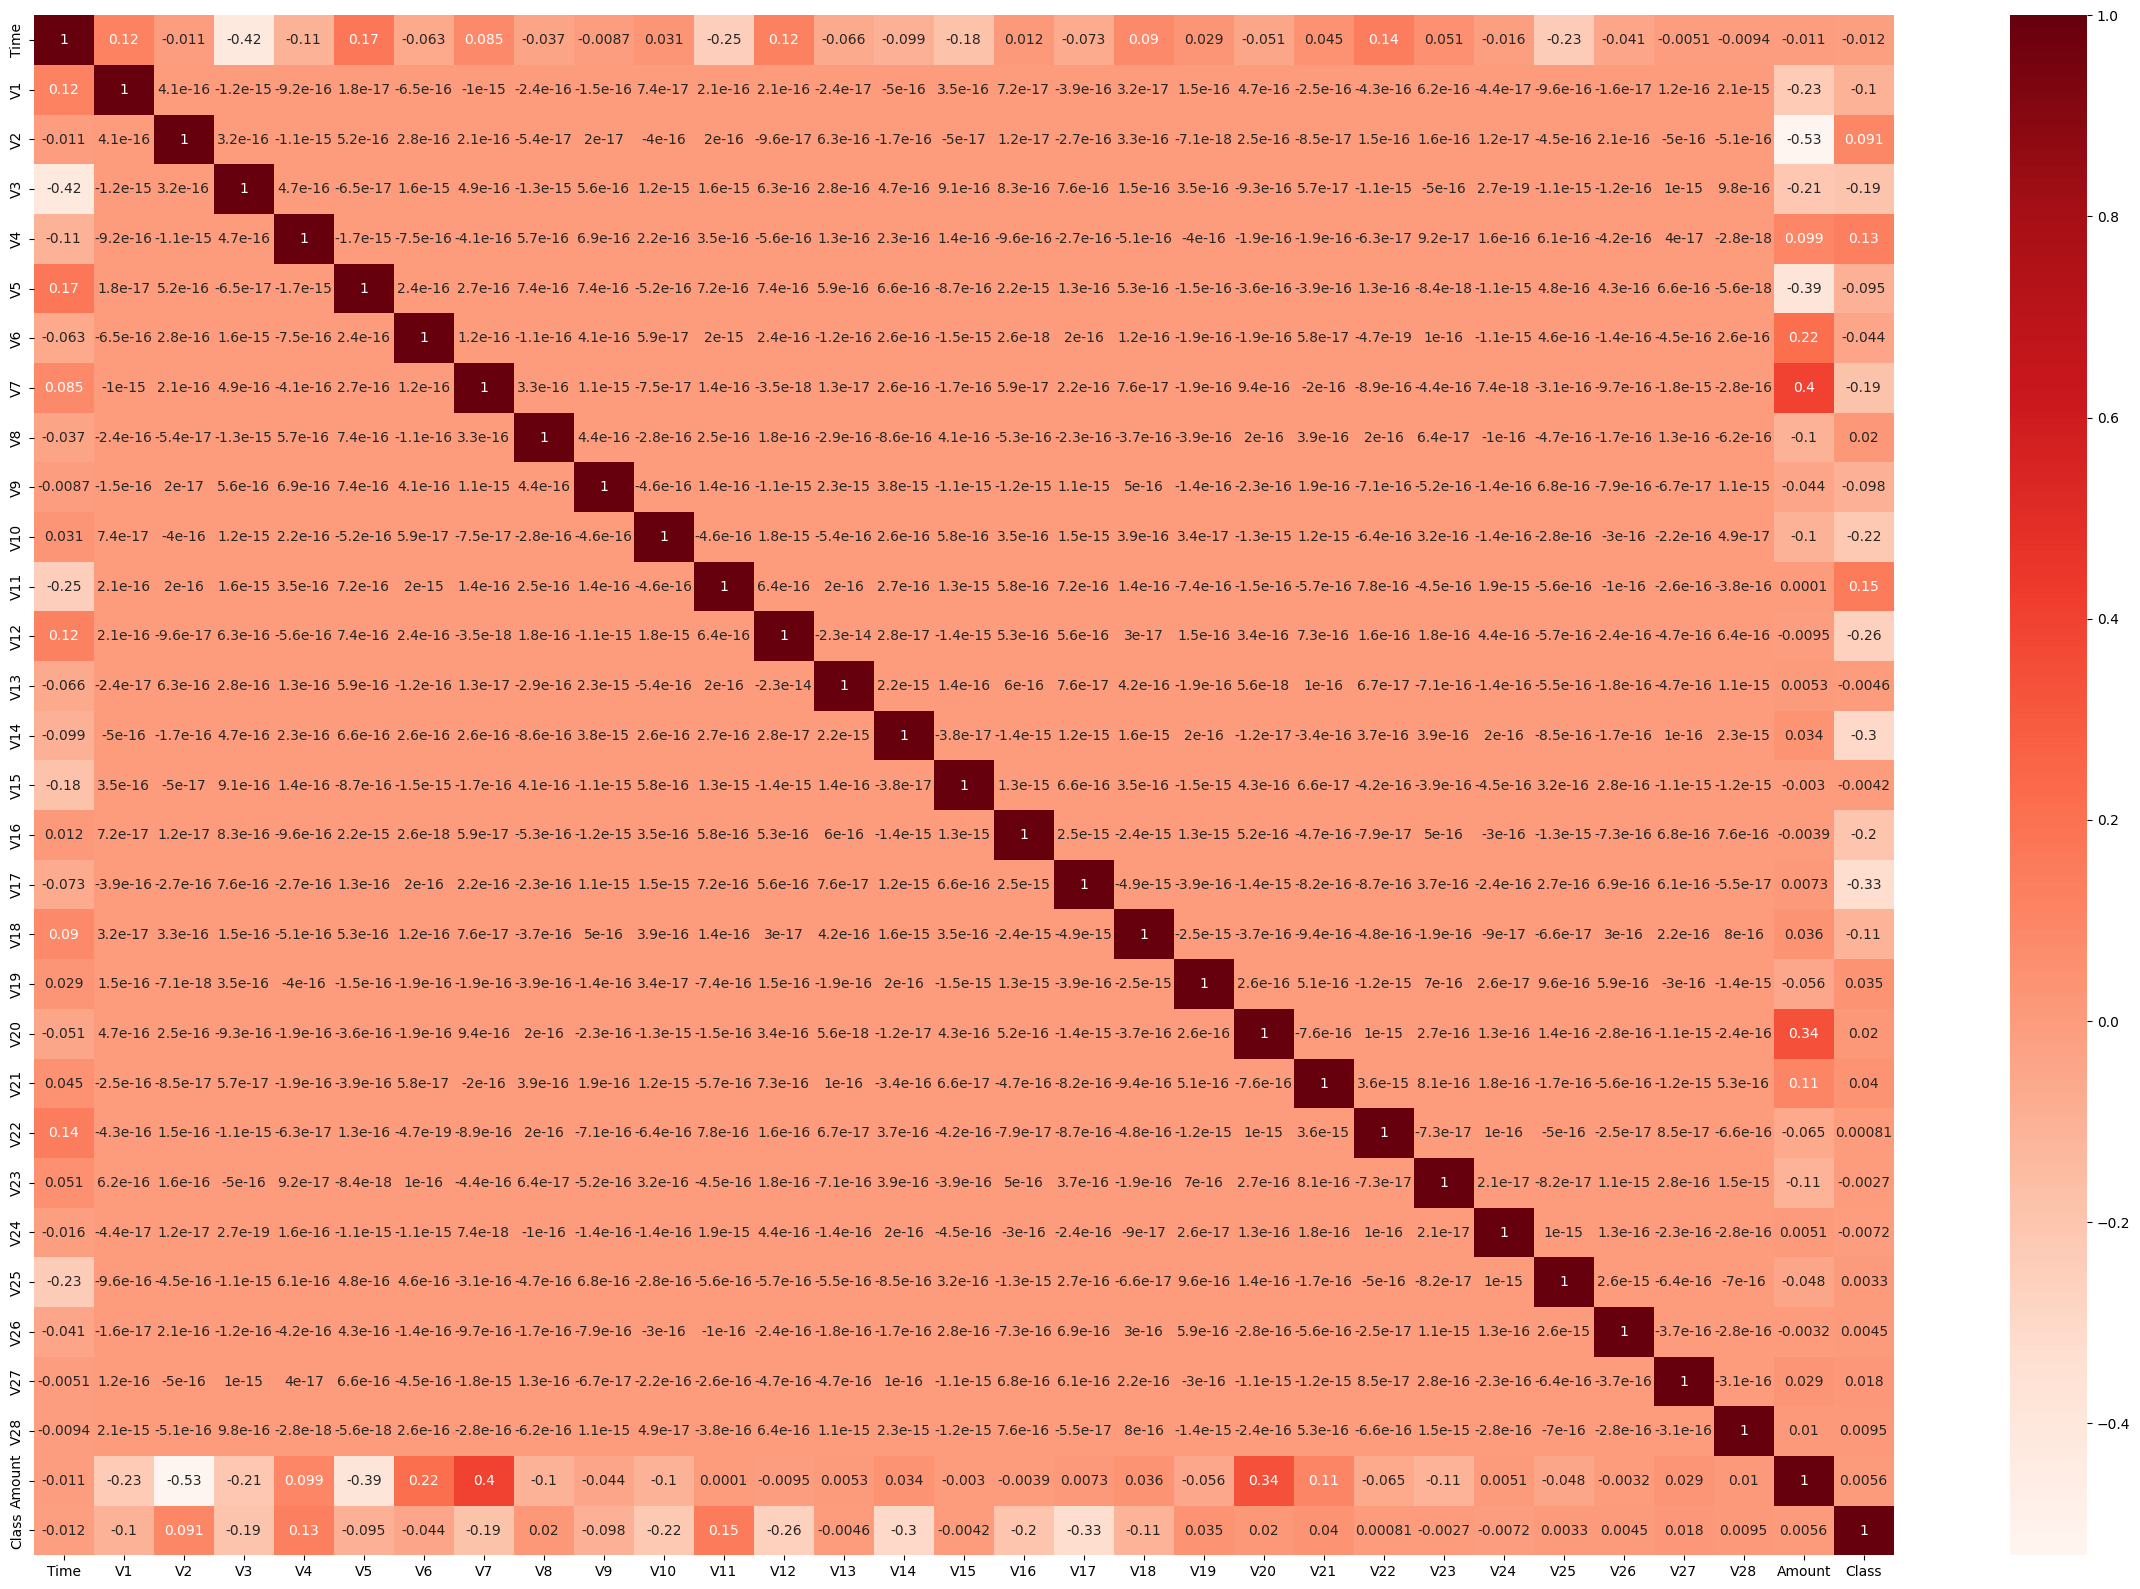

In [15]:
#Display Pearson correlation HeatMap for all variables
plt.figure(figsize=(30,20))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

top 3 independent variables {V17, V14, V12} that should contains important information about whether a giving credit card transaction is fraudulent or not

<Axes: xlabel='V13', ylabel='V17'>

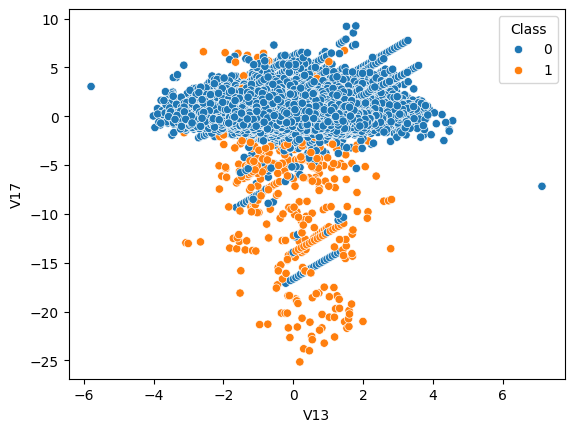

In [16]:
sns.scatterplot(x=df['V13'], y=df['V17'], hue=df['Class'])

We can notice in all three plots we can draw a horizontal line that classifies almost all data points into their correct Class value. In other words, if we look at the y-axis that corresponds to one of the interesting variables {V17, V14, V12}, then we can see that most fraudulent data points are located below the value of -5 and normal data points are located above.

In contrast, if we look at the x-axis where the boring variable is, then both fraudulent and normal data points are almost equally distributed between -4 and 4, which means that we can't draw a vertical line to separate the two groups.

<Axes: xlabel='V25', ylabel='V14'>

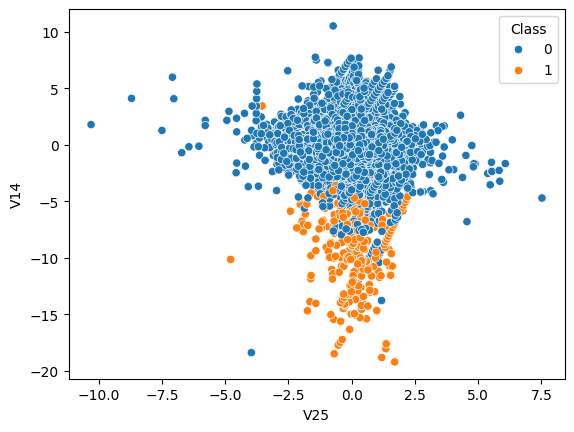

In [18]:
sns.scatterplot(x=df['V25'], y=df['V14'], hue=df['Class'])


<Axes: xlabel='V17', ylabel='Density'>

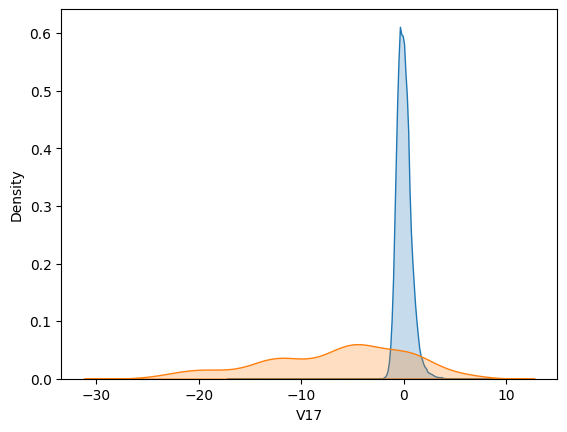

In [19]:
# Plot KDE for V17 values that belong to Class 0 (Normal)
sns.kdeplot(data=df[df['Class'] == 0]['V17'], label="Class 0", shade=True)
# Plot KDE for V17 values that belong to Class 1 (Fraud)
sns.kdeplot(data=df[df['Class'] == 1]['V17'], label="Class 1", shade=True)

<Axes: xlabel='V14', ylabel='Density'>

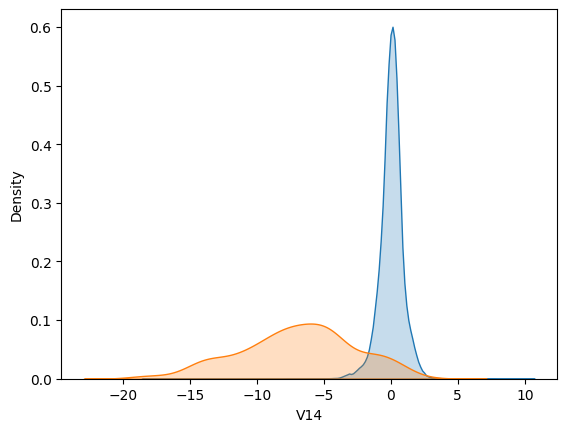

In [20]:
sns.kdeplot(data=df[df['Class'] == 0]['V14'], label="Class 0", shade=True)
sns.kdeplot(data=df[df['Class'] == 1]['V14'], label="Class 1", shade=True)

<Axes: xlabel='V25', ylabel='Density'>

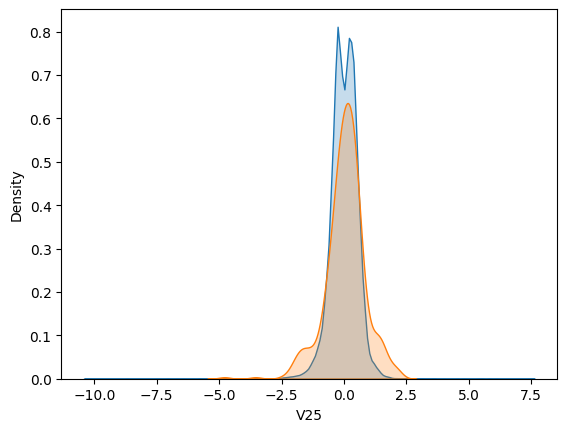

In [21]:
sns.kdeplot(data=df[df['Class'] == 0]['V25'], label="Class 0", shade=True)
sns.kdeplot(data=df[df['Class'] == 1]['V25'], label="Class 1", shade=True)

- In every interesting variable, the distribution of the normal transaction takes a shape that very close to the standard normal distribution.
- In every interesting variable, the distribution of the fraudulent transaction takes a shape that very close to a normal distribution with height standard deviation (highly spread).
- In the boring variable, both fraudulent and normal transactions have the same distribution. close to standard normal distribution.

# Kolmogorov Smirnov Two Sample Test

For any feature, the KS test:

Computes the cumulative distribution functions (CDFs) of the two samples

Measures the maximum vertical distance between those CDF curves

Returns:

D = the KS statistic (range: 0 → 1)

p = the p-value

A higher KS statistic = stronger discrimination power.

A lower KS statistic = weak or no discrimination.

In [33]:
var = df.columns.values

In [34]:
var

array(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'Amount', 'Class'], dtype=object)

In [38]:
# Kolmogorov Smirnov Two Sample Test - Discriminating power

from scipy.stats import ks_2samp

features = [c for c in df.columns if c not in ['Class']]
i = 0
t0 = df.loc[df['Class'] == 0]
t1 = df.loc[df['Class'] == 1]

for feature in features:    
    test = ks_2samp(t0[feature],t1[feature])
    print(feature,'KS:',"{0:.2f}".format(test[0]))

Time KS: 0.17
V1 KS: 0.48
V2 KS: 0.63
V3 KS: 0.70
V4 KS: 0.77
V5 KS: 0.44
V6 KS: 0.49
V7 KS: 0.66
V8 KS: 0.37
V9 KS: 0.58
V10 KS: 0.80
V11 KS: 0.76
V12 KS: 0.78
V13 KS: 0.10
V14 KS: 0.84
V15 KS: 0.06
V16 KS: 0.69
V17 KS: 0.75
V18 KS: 0.50
V19 KS: 0.33
V20 KS: 0.36
V21 KS: 0.52
V22 KS: 0.06
V23 KS: 0.18
V24 KS: 0.13
V25 KS: 0.09
V26 KS: 0.09
V27 KS: 0.47
V28 KS: 0.37
Amount KS: 0.27


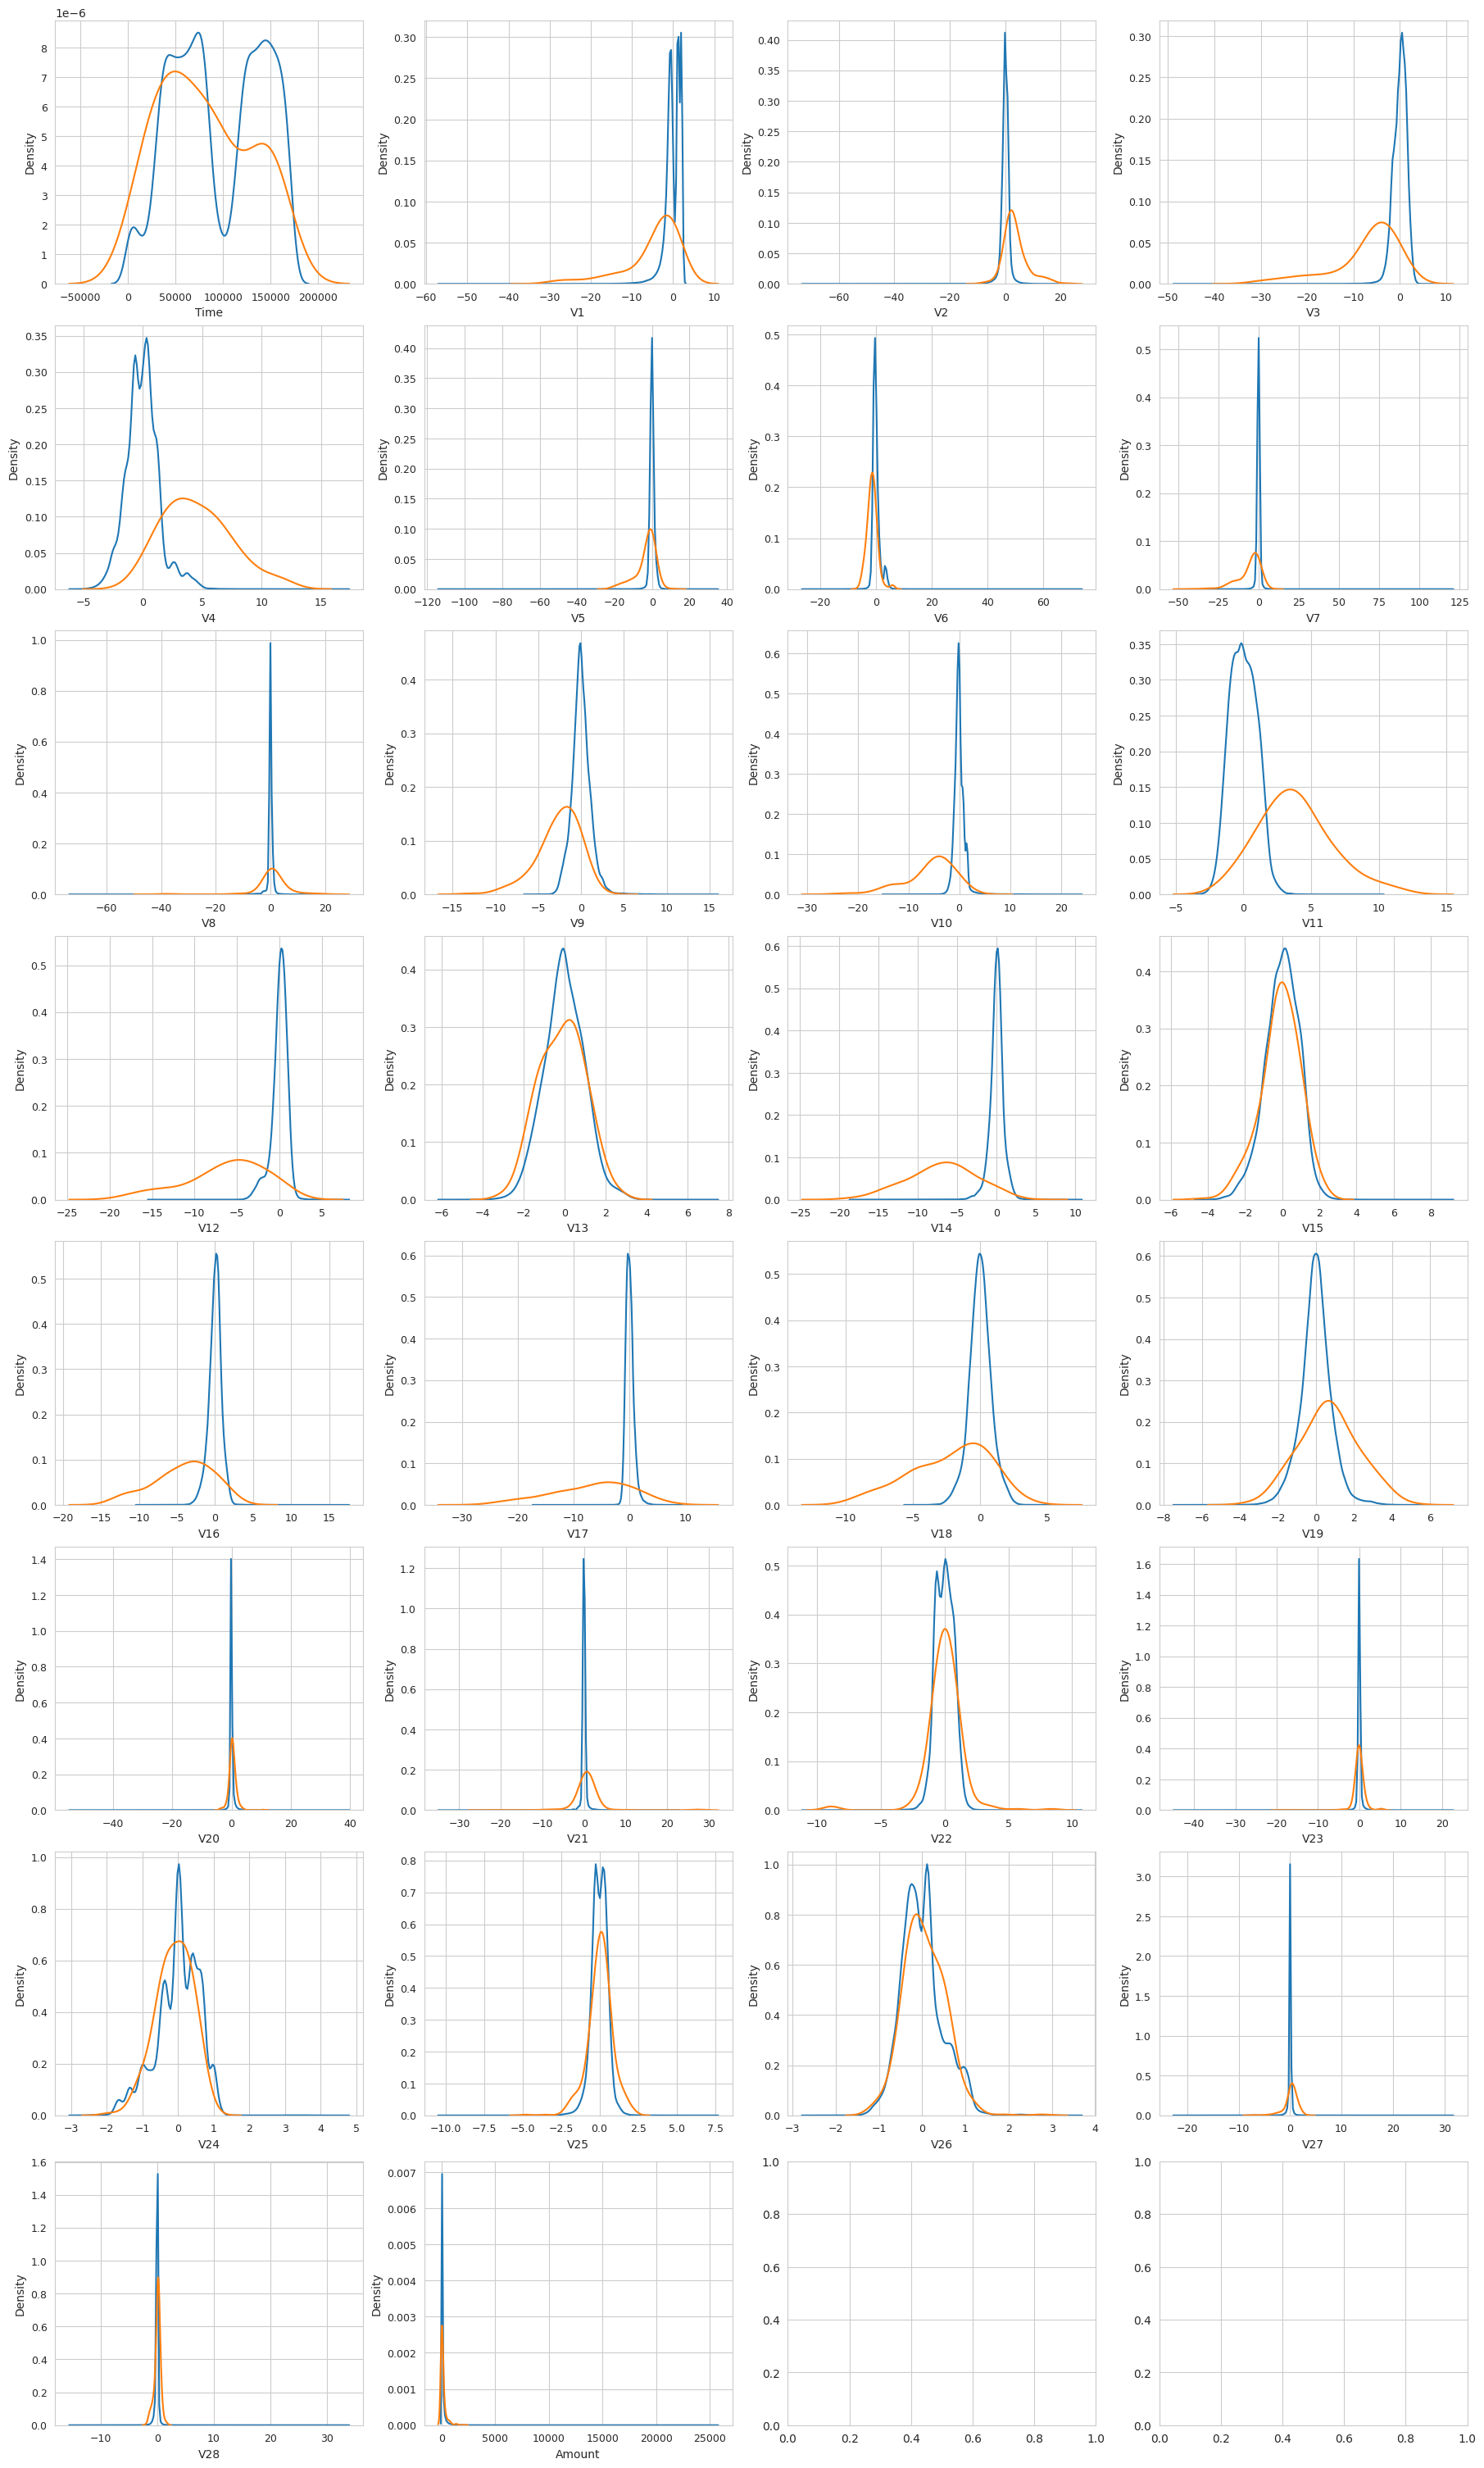

In [42]:
features = [c for c in df.columns if c not in ['Class']]

t0 = df[df['Class'] == 0]
t1 = df[df['Class'] == 1]

sns.set_style('whitegrid')

fig, axes = plt.subplots(
    8, 4,
    figsize=(18, 30),
    constrained_layout=True   # ⭐ key fix
)

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.kdeplot(
        data=t0, x=feature,
        bw_adjust=1.5,
        label="Class 0",
        ax=axes[i]
    )
    sns.kdeplot(
        data=t1, x=feature,
        bw_adjust=1.5,
        label="Class 1",
        ax=axes[i]
    )
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].tick_params(axis='both', labelsize=9)

plt.show()


- Key Findings:

    - Top Predictors: Features V14 (0.84), V10 (0.80), and V4 (0.77) achieved the highest KS scores. This indicates that the distribution of these values is fundamentally different for fraud cases compared to normal transactions, making them critical for the model.

    - Weak Features: Features like V13 (0.10), V26 (0.09), and V22 (0.06) show very little separation. These features likely contain mostly noise and may not contribute significantly to classification performance.

# Feature Selection by Random Forest 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


df = pd.read_csv('../data/creditcard.csv')
features = [c for c in df.columns if c.startswith('V')]
features += ['Amount', 'Time']


X = df[features]
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=50,       # stabilizes importance
    class_weight='balanced',   # crucial for fraud
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)


,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,50
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
importances = pd.Series(
    rf.feature_importances_,
    index=features
).sort_values(ascending=False)

importances.head(10)


V14    0.198382
V10    0.124762
V4     0.120562
V17    0.092371
V11    0.075866
V12    0.066298
V3     0.057182
V7     0.033615
V16    0.029861
V2     0.027921
dtype: float64

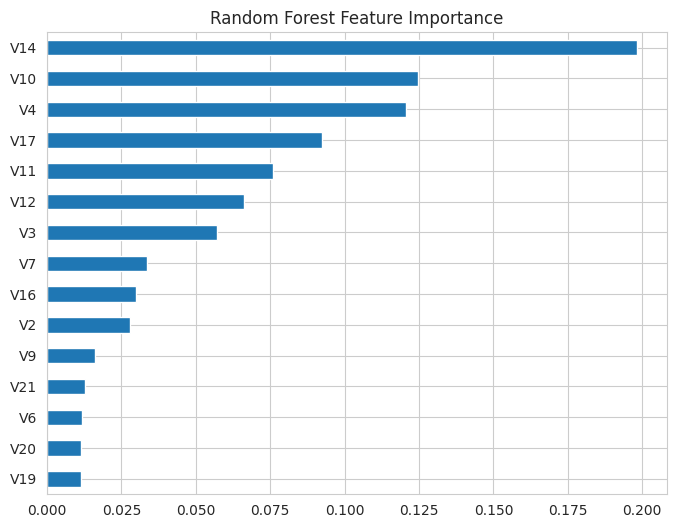

In [ ]:
importances.head(15).plot(kind='barh', figsize=(8,6))
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance")
plt.show()


- Key Findings:

    - Top Predictors: The model is heavily dependent on V14, V10, and V4, which are the top three features. V14 alone holds an importance score of ~0.17, making it the most critical feature for this classifier.

    - Alignment with EDA: These top features match exactly with the high-scoring variables from the KS Test earlier, confirming that the statistical separation we observed translates directly into model performance.

    - The "Long Tail": The importance drops off significantly after the top 10 features. Variables like V13, V22, and Amount contribute very little to the decision trees, suggesting they could be candidates for removal to simplify the model.

# Outlier Detection for gold features

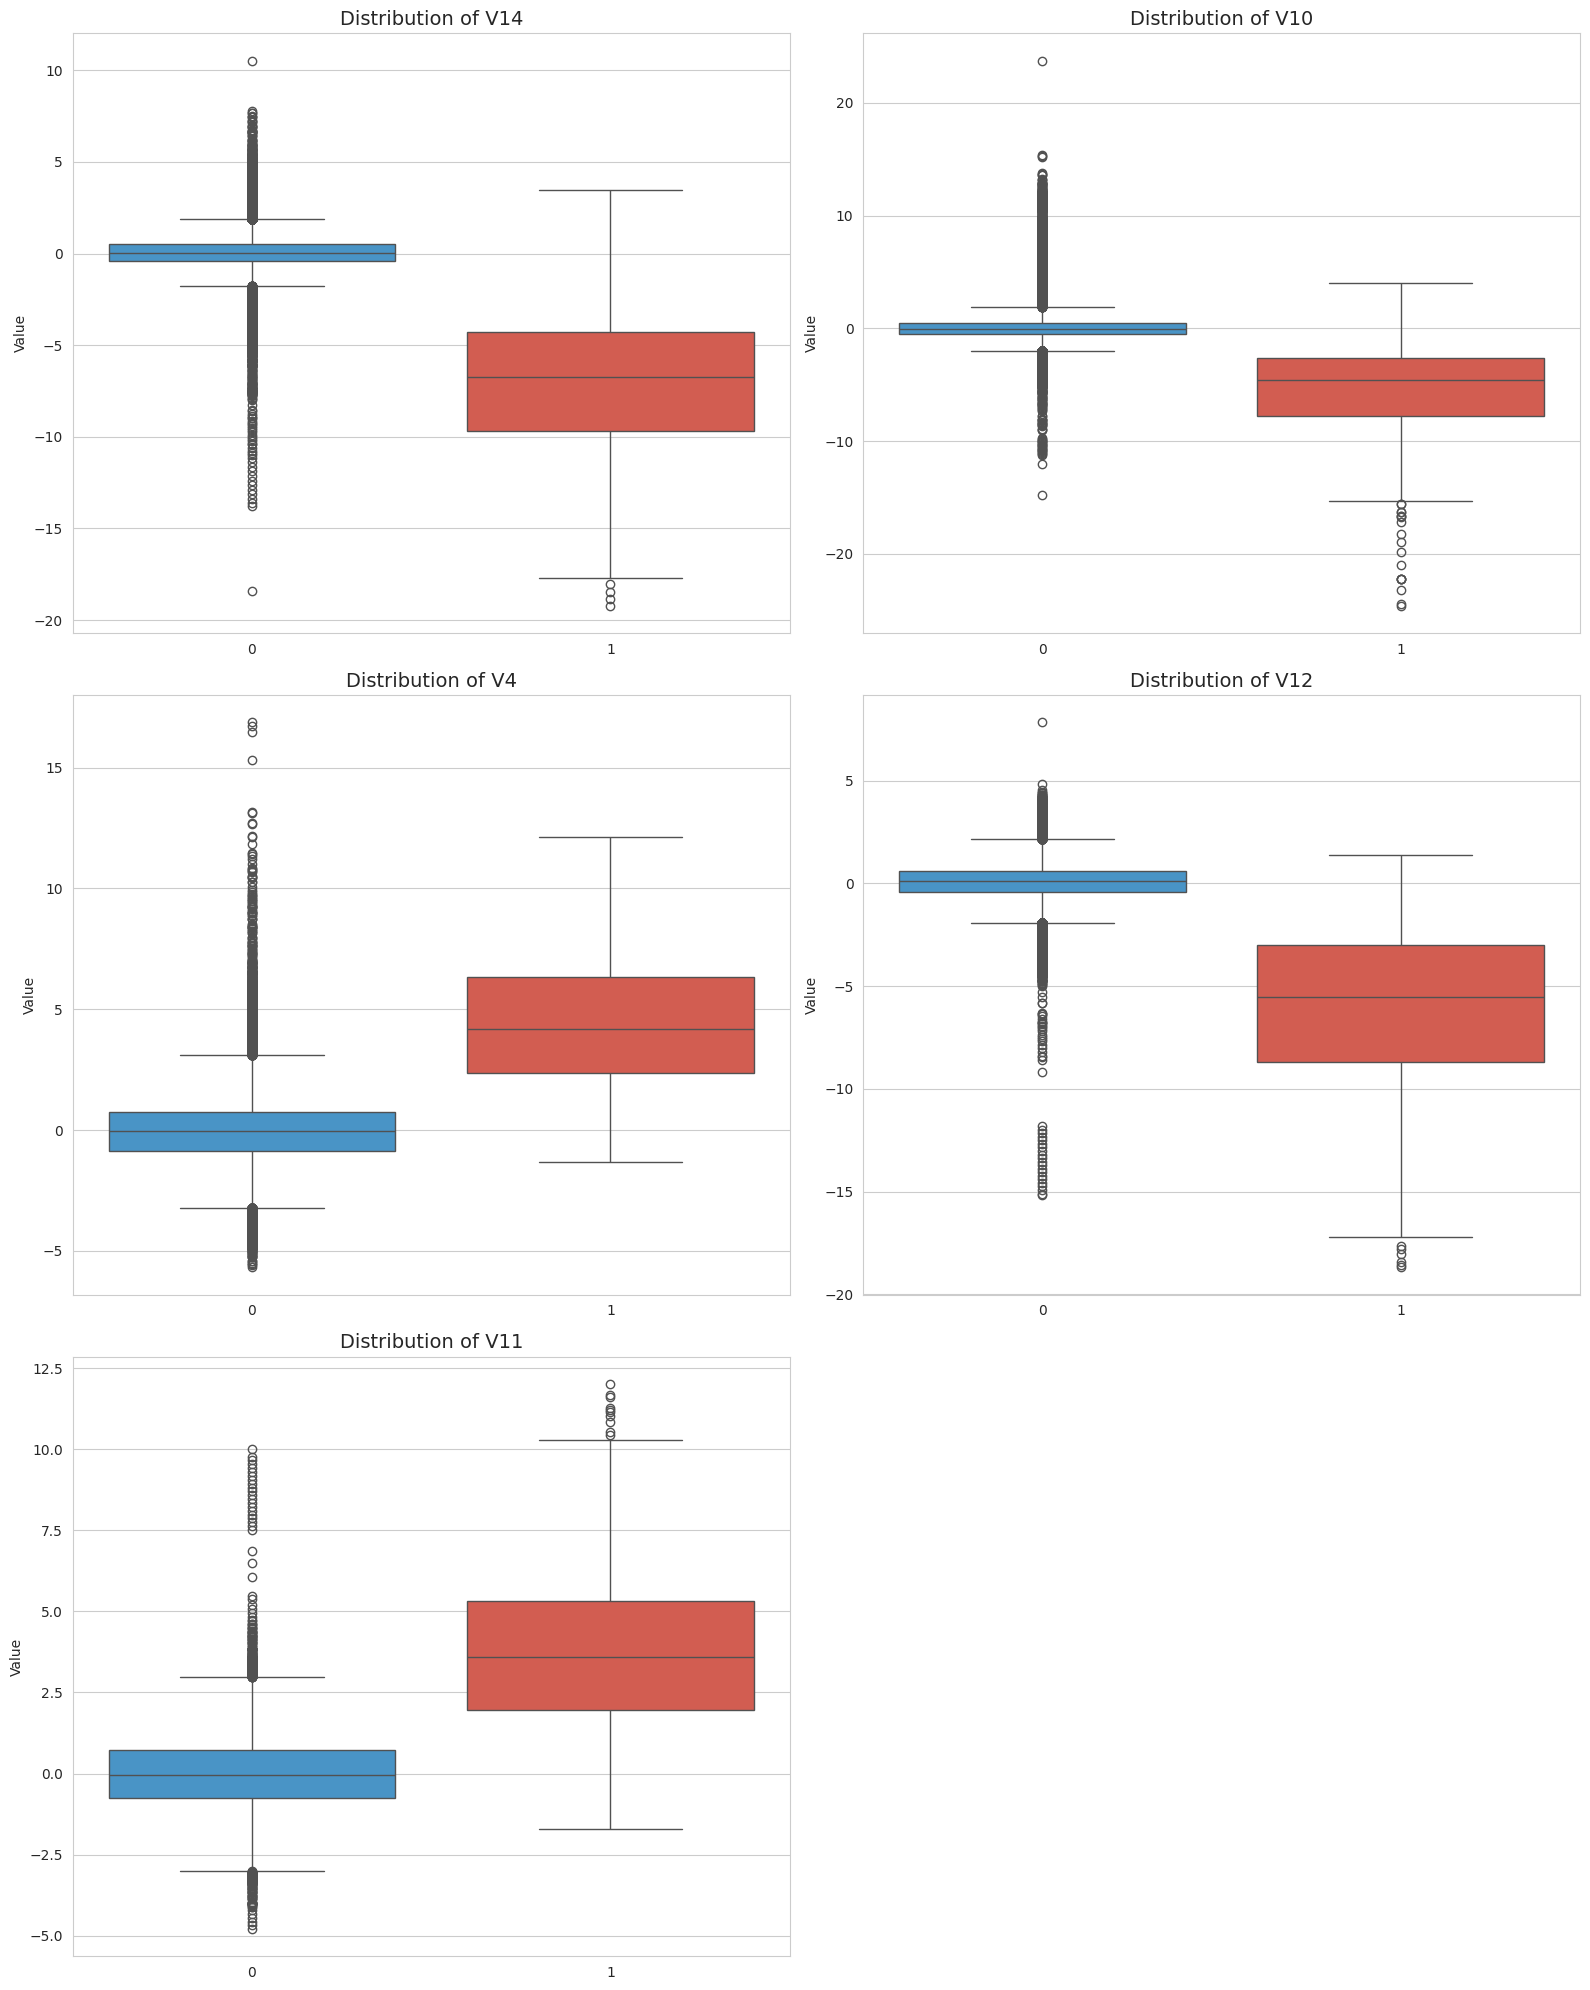

In [ ]:
import math

cols = ['V14', 'V10', 'V4', 'V12', 'V11']

# Setup the grid (e.g., 2 columns, 5 rows)
n_cols = 2
n_rows = math.ceil(len(cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 20))
axes = axes.flatten()

for i, col in enumerate(cols):
    # Plot each feature on its own axis
    sns.boxplot(x='Class', y=col, data=df, ax=axes[i], 
                palette=["#3498db", "#e74c3c"])
    
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Value')
    
# Remove empty subplots if you have an odd number of features
if len(cols) < len(axes):
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- The visual analysis confirms that features such as V14, V10, and V4 possess high discriminative power. Fraudulent transactions consistently inhabit a different value range compared to legitimate ones, typically exhibiting extreme negative values for V14 and V10, and high positive values for V4 and V11.

- The visual analysis reveals a critical challenge: Feature Overlap via Outliers. While the interquartile ranges (IQRs) of Normal vs. Fraud classes are well-separated, the extreme outliers in the Normal class frequently intrude into the value ranges typical of Fraud.

    -  For example, in V14 and V10, legitimate transaction outliers extend deep into the negative values occupied by fraud cases. This indicates that simple linear thresholding will result in high False Positive rates. The model must learn to distinguish 'dense' fraud clusters from 'sparse' legitimate outliers."

# t-SNE Visualization (Cluster Analysis)

Running t-SNE... this might take a minute.


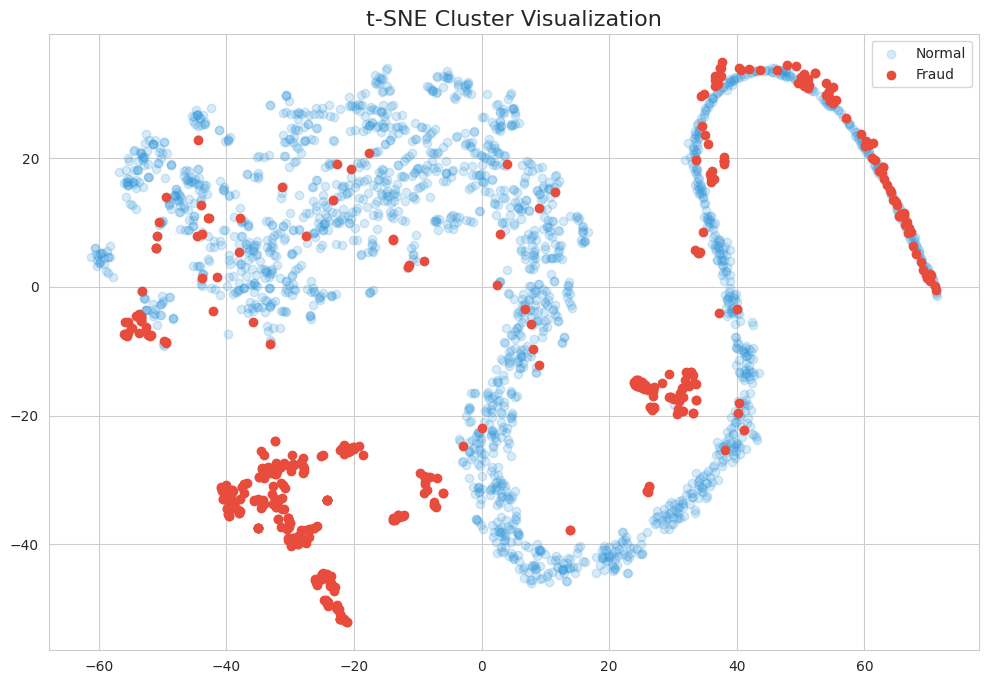

In [ ]:
from sklearn.manifold import TSNE
import time

# 1. Stratified Sampling to speed up t-SNE
# Take ALL fraud cases
df_fraud = df[df['Class'] == 1]
# Take a random sample of 2000 normal cases
df_normal = df[df['Class'] == 0].sample(n=2000, random_state=42)

# Combine them
df_sub = pd.concat([df_fraud, df_normal])
X_sub = df_sub.drop(['Class', 'Time'], axis=1) # Drop Time if you want purely feature-based clustering
y_sub = df_sub['Class']

# 2. Run t-SNE
print("Running t-SNE... this might take a minute.")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_embedded = tsne.fit_transform(X_sub)

# 3. Plot Result
plt.figure(figsize=(12, 8))
plt.scatter(X_embedded[y_sub == 0, 0], X_embedded[y_sub == 0, 1], c='#3498db', alpha=0.2, label='Normal')
plt.scatter(X_embedded[y_sub == 1, 0], X_embedded[y_sub == 1, 1], c='#e74c3c', alpha=1.0, label='Fraud')
plt.title("t-SNE Cluster Visualization", fontsize=16)
plt.legend()
plt.show()

The t-SNE visualization demonstrates that the dataset is highly separable. The Fraud cases (Red) do not randomly mix with Normal cases (Blue); instead, they form a distinct, tight cluster. This suggests that despite the class imbalance, there is a clear underlying pattern that distinguishes fraudulent behavior.

# Apply Rule

In [ ]:
from sklearn.metrics import accuracy_score
import sklearn

In [ ]:
df['Hour'] = df['Time'].apply(lambda x: np.floor(x / 3600) % 24)

# Rule: Flag transactions occurring between 2 AM and 4 AM (inclusive)
# Cell 12 shows a "massive hump" of fraud during these hours.
time_rule_y = [1 if (h >= 2 and h <= 4) else 0 for h in df['Hour']]


In [ ]:
# Display confusion matrix for our high accuracy classifier
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, time_rule_y)

TN = confusion_matrix[0][0] 
FP = confusion_matrix[0][1] 
FN = confusion_matrix[1][0] 
TP = confusion_matrix[1][1] 
# Recall
recall = TP/(TP+FN)

print("Recall: ", recall)

Recall:  0.19715447154471544


In [ ]:
# Rule: Flag if the transaction Amount is 0
# Cell 17 Findings: "Zero-amount transactions are significantly more likely to be fraudulent"
zero_amount_y = [1 if a == 0 else 0 for a in df['Amount']]

In [ ]:
# Display confusion matrix for our high accuracy classifier
confusion_matrix = sklearn.metrics.confusion_matrix(y, zero_amount_y)

TN = confusion_matrix[0][0] 
FP = confusion_matrix[0][1] 
FN = confusion_matrix[1][0] 
TP = confusion_matrix[1][1]
# Recall
recall = TP/(TP+FN)

print("Recall: ", recall)

Recall:  0.054878048780487805


In [ ]:

# Rule: Classify as Fraud (1) if V4 is greater than 3 and -1.05, otherwise Normal (0)
# Normal transactions are clustered around 0, while Fraud tends to be high positive.
v4_accuracy_y = [0 if i>-1.05 and i<3 else 1 for i in df['V14']]


In [ ]:
# Display confusion matrix for our high accuracy classifier
confusion_matrix = sklearn.metrics.confusion_matrix(y, v4_accuracy_y)

TN = confusion_matrix[0][0]
FP = confusion_matrix[0][1] 
FN = confusion_matrix[1][0]
TP = confusion_matrix[1][1]
# Recall
recall = TP/(TP+FN) 

print("Recall: ", recall)

Recall:  0.9024390243902439


In [ ]:
combined_accuracy_y = [
    1 if (v14 < -5 or v4 > 4) else 0 
    for v14, v4 in zip(df['V14'], df['V4'])
]

In [ ]:
# Display confusion matrix for our high accuracy classifier
confusion_matrix = sklearn.metrics.confusion_matrix(y, combined_accuracy_y)

TN = confusion_matrix[0][0] 
FP = confusion_matrix[0][1] 
FN = confusion_matrix[1][0]
TP = confusion_matrix[1][1]
# Recall
recall = TP/(TP+FN) 

print("Recall: ", recall)

Recall:  0.7215447154471545


In [ ]:
# Define the Voting Logic
def voting_classifier(row):
    score = 0
    # Add a point for every suspicious feature value found in EDA
    if row['V14'] < -1.05 or row['V14'] > 3: score += 1
    if row['V17'] < -1 or row['V17'] > 2.5: score += 1
    if row['V12'] < -3.5 or row['V12'] > 1.5: score += 1
    
    # Threshold: If 2 or more indicators are present, classify as Fraud
    return 1 if score >= 2 else 0

# Apply the rule
voting_y = [voting_classifier(row) for index, row in df.iterrows()]


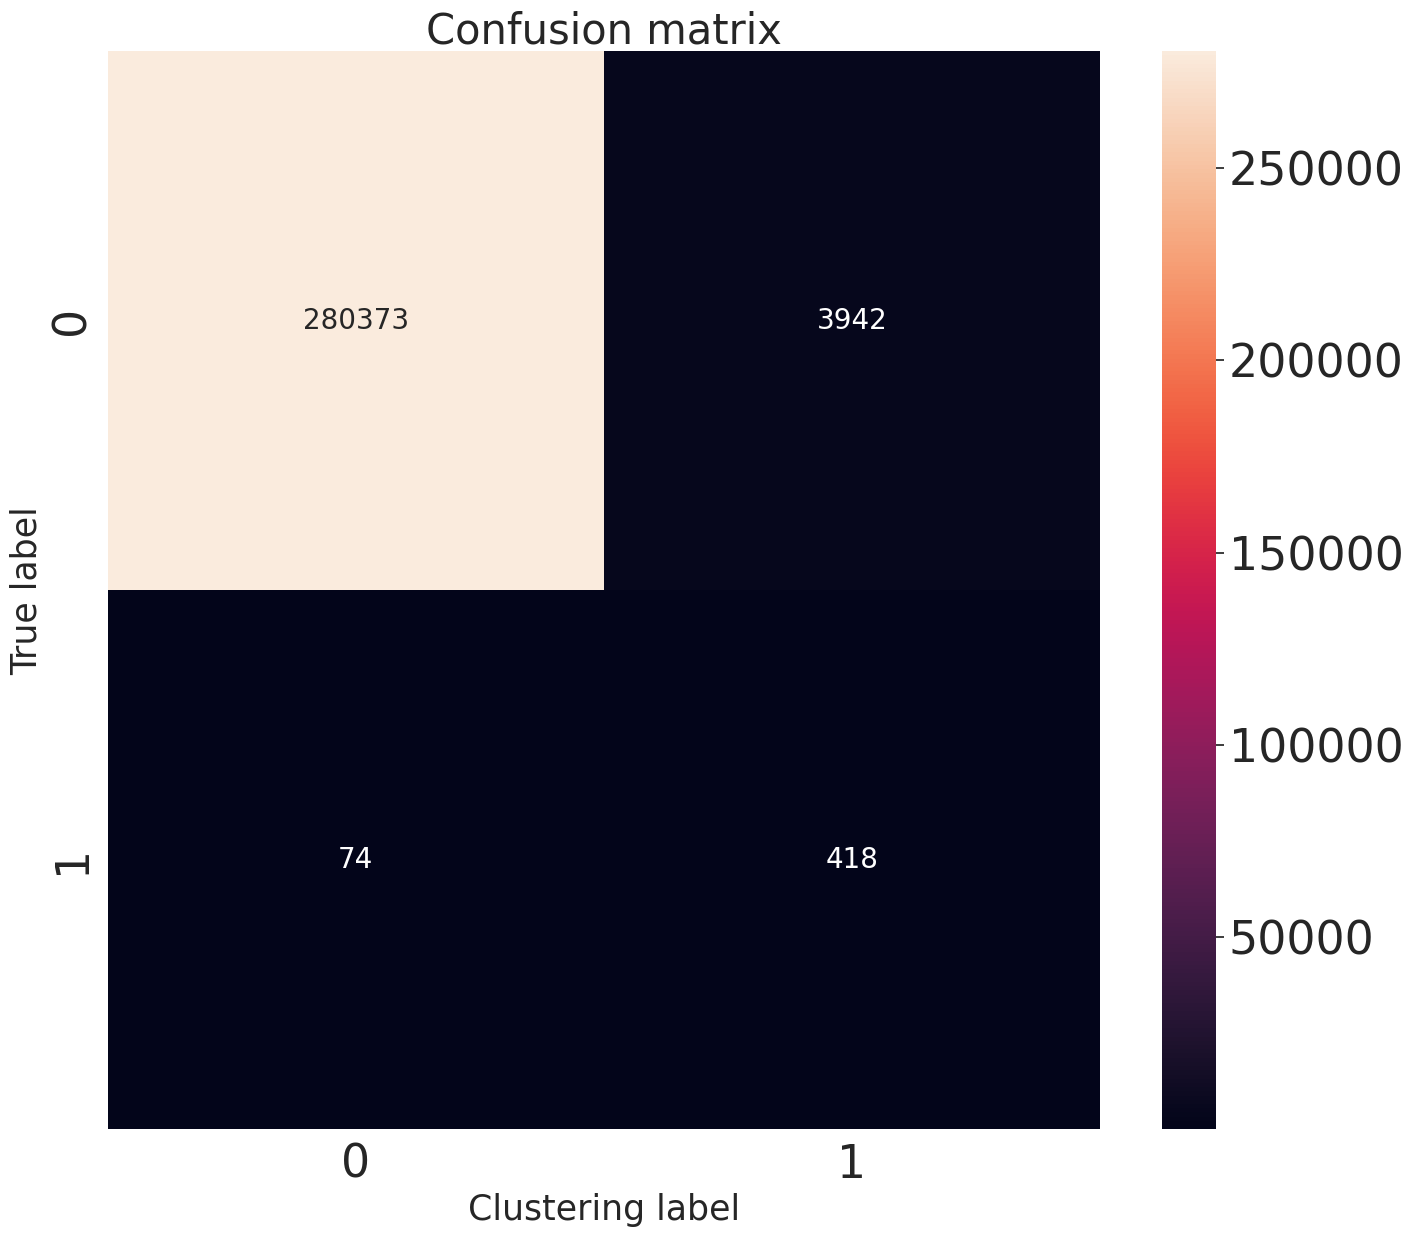

Recall:  0.8495934959349594


In [ ]:
# Display confusion matrix for our high accuracy classifier
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, voting_y)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

TN = confusion_matrix[0][0] 
FP = confusion_matrix[0][1] 
FN = confusion_matrix[1][0] 
TP = confusion_matrix[1][1]
# Recall
recall = TP/(TP+FN) 

print("Recall: ", recall)